# Re-training a model using PyTorch and Transfer Learning

Let us retrain the [ResNet-50 model](https://arxiv.org/pdf/1512.03385.pdf) from PyTorch Hub using the CIFAR-10 dataset.

The CIFAR-10 dataset is used to retrain the default model using the [transfer learning technique](https://www.youtube.com/watch?v=BqqfQnyjmgg&list=PLo2EIpI_JMQtNtKNFFSMNIZwspj8H7-sQ&index=3).

We aim to build upon this pre-trained model using PyTorch and then export it to ONNX format for optimized and versatile inference. This approach demonstrates a practical method of applying transfer learning to adapt existing models for new data.

## 🛠️ Supported Hardware

This notebook can run in a CPU or in a GPU.

✅ AMD Instinct™ Accelerators  
✅ AMD Radeon™ RX/PRO Graphics Cards  
✅ AMD EPYC™ Processors  
✅ AMD Ryzen™ (AI) Processors  

Suggested hardware: **AI PC powered by AMD Ryzen™ AI Processors**

## ⚡ Recommended Software Environment

::::{tab-set}

:::{tab-item} Linux
- [Install Docker container](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::

:::{tab-item} Windows
- [Install Direct-ML](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu-windows.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::
::::

## 🎯 Goals

- **Learn how to retrain a model** using PyTorch with transfer learning techniques.
- **Export a trained model to ONNX** for broader deployment options.


```{seealso}
- [ResNet-50 model](https://arxiv.org/pdf/1512.03385.pdf)
- **[CIFAR-10 Dataset](https://github.com/EN10/CIFAR)**  Access CIFAR-10, a dataset for benchmarking computer vision tasks.
```

## Import packages

Run the following cell to import all the necessary packages.

In [ ]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.datasets import CIFAR10
import random
import urllib.request
import tarfile
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import pandas as pd
import os
import enum
import pickle

## Load the pre-trained ResNet50 model

The pre-trained ResNet-50 model trained on 1,000 class `ImageNet` dataset by default has fully connected (FC) layer of output size 1,000. This means that it produces a 1,000-dimensional vector, where each dimension corresponds to a class in the `ImageNet` dataset.

We will use transfer learning to select a set of pre-trained weights for the model and then customize the model classifier by replacing its FC layers. The modification includes adding two linear layers, one with 2,048 input features and 64 output features, followed by a ReLU activation function, and another linear layer with 64 input features and 10 output features. This adaptation transforms the ResNet-50 model into a classifier suitable for a specific task with 10 classes. 

In [2]:
def load_resnet_model():
    weights = ResNet50_Weights.DEFAULT
    resnet = resnet50(weights=weights)
    resnet.fc = torch.nn.Sequential(torch.nn.Linear(2048, 64), torch.nn.ReLU(inplace=True), torch.nn.Linear(64, 10))
    return resnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device=}')
model = load_resnet_model().to(device)

Using device=device(type='cpu')


## Download the CIFAR-10 dataset

Execute the following cells to download the CIFAR-10 dataset. The dataset is stored in `dataset/cifar-10-batches-py/`.

In [ ]:
datadirname = "datasets"
if not os.path.exists(datadirname):
   data_download_tar = "cifar-10-python.tar.gz"
   urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", data_download_tar)
   file = tarfile.open(data_download_tar)
   file.extractall(datadirname)
   file.close()

The [CIFAR-10](https://github.com/EN10/CIFAR) dataset has 60,000 32x32 pixels color images in 10 classes, each class consists of 6,000 images.
There are 50,000 training images and 10,000 test images.   
The dataset contains five training batches and one test batch, 10,000 images in each. Each class in the test batch has 1,000 randomly selected images.

In [4]:
class Cifar10Classes(enum.Enum):
    airplane = 0
    automobile = 1
    bird = 2
    cat = 3
    deer = 4
    dog = 5
    frog = 6
    horse = 7
    ship = 8
    truck = 9

Extract the dataset in the directory

In [ ]:
def unpickle(file):
    with open(file,'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

datafile = os.path.join(datadirname, 'cifar-10-batches-py', 'test_batch')
metafile = os.path.join(datadirname, 'cifar-10-batches-py', 'batches.meta')

test_batch = unpickle(datafile)
metadata = unpickle(metafile)

images = test_batch['data']
labels = test_batch['labels']
images = np.reshape(images,(10000, 3, 32, 32))

im = []

dirname = os.path.join('datasets', 'test_images')
if not os.path.exists(dirname):
   os.mkdir(dirname)

Visualize a sample of the dataset

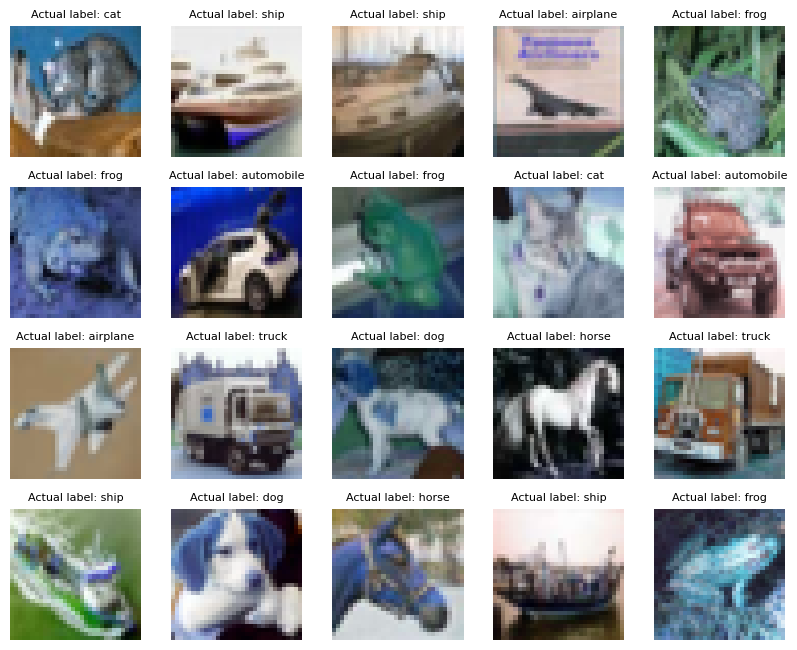

In [6]:
for i in range(20):
    im.append(cv2.cvtColor(images[i].transpose(1,2,0), cv2.COLOR_RGB2BGR))

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 5),  # creates 4x5 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, im, labels):
    ax.axis("off")
    ax.imshow(image)
    ax.set_title(f'Actual label: {Cifar10Classes(label).name}', fontdict={'fontsize':8})

plt.show()

## Model re-training

The training process runs over 500 images with a `batch_size` of 100, i.e., over the total 50,000 images in the train set.

The training process takes approximately 10 minutes to complete each epoch. Number of epochs can be varied to optimize the accuracy of the model.

In [7]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def prepare_model(num_epochs=0):
    random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0) # Seed everything to 0

    # Hyper-parameters
    num_epochs = num_epochs
    learning_rate = 0.001

    transform = transforms.Compose(
        [transforms.Pad(4), transforms.RandomHorizontalFlip(), transforms.RandomCrop(32), transforms.ToTensor()]
    ) # Image preprocessing modules

    # CIFAR-10 dataset
    train_dataset = CIFAR10(root=datadirname, train=True, transform=transform, download=False)
    test_dataset = CIFAR10(root=datadirname, train=False, transform=transforms.ToTensor())

    # Data loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    curr_lr = learning_rate
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels)
            optimizer.zero_grad() # Backward and optimize
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}]'
                      f' Loss: {loss.item():.4f}')
        if (epoch + 1) % 20 == 0: # Decay learning rate
            curr_lr /= 3
            update_lr(optimizer, curr_lr)

    # Test the model
    model.eval()
    if num_epochs:
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print("Accuracy of the model on the test images: {} %".format(accuracy))
    return model

Run the training

In [8]:
model = prepare_model(num_epochs=1)

Epoch [1/1], Step [100/500] Loss: 1.1095
Epoch [1/1], Step [200/500] Loss: 0.8919
Epoch [1/1], Step [300/500] Loss: 0.8998
Epoch [1/1], Step [400/500] Loss: 0.7694
Epoch [1/1], Step [500/500] Loss: 0.5798
Accuracy of the model on the test images: 77.39 %


Save the trained PyTorch model by running the following cell:

In [ ]:
model.to("cpu")
model_path = os.path.join('resnet50_cifar10', 'resnet_trained_for_cifar10.pt')
torch.save(model, model_path)

```{note}
A checkpoint of the model is saved in the directory `resnet50_cifar10` with the name `resnet_trained_for_cifar10.pt`
```

## Inference for more test images

```{note}
The cell below may extract up to 5,000 images. You can delete the extracted images after finishing the inference.
```

The first 5,000 images are extracted from the CIFAR-10 test dataset and converted to the `.png` format.

In [ ]:
max_images = len(images)//2

# Extract and dump all images in the test set
for i in range(max_images):
    im = images[i]
    im  = im.transpose(1,2,0)
    im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
    im_name = f'./{dirname}/image_{i}.png'
    cv2.imwrite(im_name, im)

The `.png` images are read, classified and visualized by running the ResNet-50 model your device.

In [11]:
cm_predicted_labels = []
cm_actual_labels = []

model.eval()
for i in range(max_images):
    image_name = f'{dirname}/image_{i}.png'
    try:
        image = Image.open(image_name).convert('RGB')
    except:
        print(f"Warning: Image {image_name} maybe locked moving on to next image")
        continue

    # Resize, reshape and add batch dimension to the image to match model input shape
    image = image.resize((32, 32)) 
    image_array = np.array(image).astype(np.float32)
    image_array = image_array/255
    image_array = np.transpose(image_array, (2, 0, 1))
    input_data = np.expand_dims(image_array, axis=0)

    # Run the model
    with torch.no_grad():
        outputs = model(torch.from_numpy(input_data))

    # Process the outputs
    _, predicted_class = torch.max(outputs.data, 1)
    predicted_label = metadata['label_names'][predicted_class]
    cm_predicted_labels.append(predicted_class)
    label = metadata['label_names'][labels[i]]
    cm_actual_labels.append(labels[i])
    if i%990 == 0:
        print(f'Status: Running Inference on image {i}... Actual Label: {label}'
              f' Predicted Label: {predicted_label}')

Status: Running Inference on image 0... Actual Label: cat Predicted Label: cat
Status: Running Inference on image 990... Actual Label: automobile Predicted Label: automobile
Status: Running Inference on image 1980... Actual Label: truck Predicted Label: truck
Status: Running Inference on image 2970... Actual Label: dog Predicted Label: dog
Status: Running Inference on image 3960... Actual Label: bird Predicted Label: bird
Status: Running Inference on image 4950... Actual Label: bird Predicted Label: bird


## Confusion Matrix

The X-axis represents the predicted class and the Y-axis represents the actual class.

The diagonal cells show true positives, they show how many instances of each class were correctly predicted by the model. 
The off-diagonal cells show instances where the predicted class did not match the actual class.

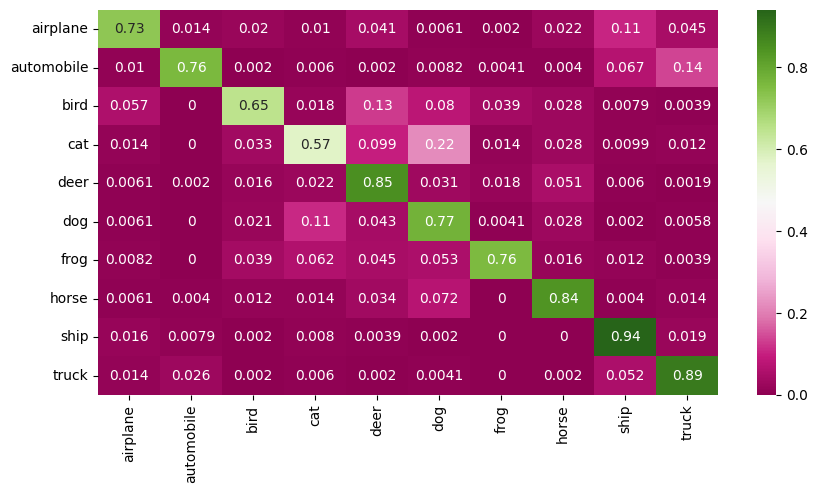

In [12]:
cf_matrix = confusion_matrix(cm_actual_labels, cm_predicted_labels)
df = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1), index = [Cifar10Classes(i).name for i in range(10)], columns=[Cifar10Classes(i).name for i in range(10)])
plt.figure(figsize = (10,5));
sn.heatmap(df, annot=True, cmap="PiYG");

## Accuracy of the quantized model for 5,000 test images

In [13]:
print(f" Accuracy of the quantized model for the test set is : {(accuracy_score(cm_actual_labels, cm_predicted_labels)*100):.2f} %")

 Accuracy of the quantized model for the test set is : 77.66 %


## Convert Model to ONNX Format

We will convert the PyTorch trained model to ONNX format, the ONNX model can then be used in [Ryzen AI SW](https://ryzenai.docs.amd.com/en/latest/index.html)

```{note}
After completing the training process, observe the following output:
The trained ResNet-50 model on the CIFAR-10 dataset is saved at the following location in ONNX format: `resnet50_cifar10/resnet_trained_for_cifar10.onnx`
```

In [ ]:
onnx_model_path = os.path.join('resnet50_cifar10', 'resnet_trained_for_cifar10.onnx')

def save_onnx_model(model):
    dummy_inputs = torch.randn(1, 3, 32, 32)
    input_names = ['input']
    output_names = ['output']
    dynamic_axes = {'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    onnx_model_path = onnx_model_path
    torch.onnx.export(
        model,
        dummy_inputs,
        onnx_model_path,
        export_params=True,
        opset_version=13,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axes,
    )

save_onnx_model(model)

## Visualize the ONNX Model with Netron

Generated and adapted using Netron
>Netron is a viewer for neural network, deep learning and machine learning models.

Display the Netron viewer in an iframe

In [ ]:
import netron
from IPython.display import IFrame

display(IFrame(src=f"https://netron.app/", width="100%", height="600px"))

----------
Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.

SPDX-License-Identifier: MIT